# One-Dimensional Sensitiviy analysis on Jupedsim for GCS

## Background

In this example we're running a simple sensitivity analysis on jupedsim. We're looking at the sensitivity of four parameters:
* **force_ped_a** The strength of the interaction when one pedestrian tries to avoid coming into contact with **another pedestrian**.
* **force_ped_D** The maximum distance another pedestrian can be to provoke a reaction (of avoiding them)
* **v_mu** The desired mean velocity of pedestrians
* **tau_mu** The mean reaction time from noticing another pedestrian to acting to avoid them

Each parameter is analysed separately. Specifically, when we change the value of one parameter, all others remain constant (at the default value suggested by Jupedsim). Therefore, we are not learning anything about interactions between parameters. 

We look at two model outputs:
* **mean density** within a given zone, averaged across each frame for a period of two minutes.
* **standard deviation of density** within a given zone over the same period of two minutes.

We measure these outputs in two *zones*. 
* **zone 1** a high density area in the data.
* **zone 2** a low density earea in the data.
The figure below shows the population density in the data (not the model) averaged over two minutes and represented as a heatmap. Blue indicates low density, yellow/red is high.

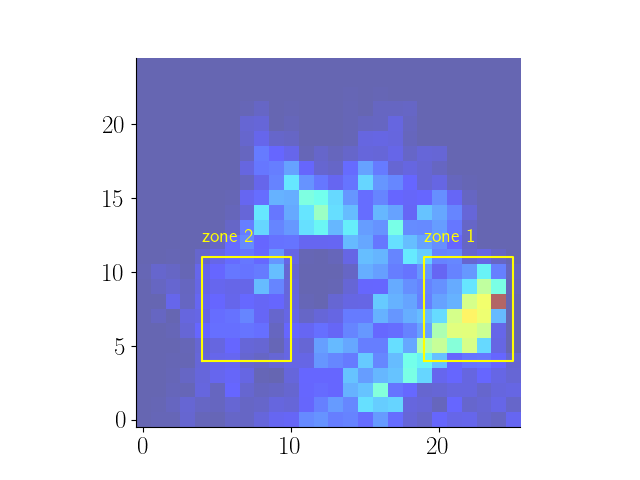

In [1]:
# Plot pre-calculated density map of the GCS data.
# Density is sample once every 30 seconds over 2 minutes.
# The environment is split into a grid with each square at 2m wide.
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
image = Image.open(parent_dir + '/data/figures/average_density_zones.png')
display(image)

The model has already been run in advance with different parameters.
First some code to set up plotting the results:

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

N = 30
report_fp = '/Fundamental_Diagram/Classical_Voronoi/rho_v_Voronoi_Voronoi_traj.txt_id_'


def get_param_values(problem):
    """ Generate parameters using the defined problem. """
    return saltelli.sample(problem, N)


def get_report_results(results_fp, zone_no):
    """ Fetch the population density results within the given zone. """
    with open('%s/sa_timestamps.pkl' % results_fp, 'rb') as pfile:
        timestamps = pickle.load(pfile)
    n = len(timestamps)
    M = np.zeros(n)
    SIGMA = np.zeros(n)
    for t in range(n):
        fp = '%s/report_results_%s%s%d.dat' % (results_fp, timestamps[t], report_fp, zone_no)
        zone = pd.read_csv(fp, sep='\t', skiprows=2)
        # fix reading of columns caused by extra whitespace
        zone.pop('Voronoi velocity(m/s)')
        zone.columns = ['frame', 'density', 'velocity']
        M[t] = np.mean(zone['density'])
        SIGMA[t] = np.var(zone['density'], ddof=1)
    return M, SIGMA


def plot_report_results(problem):
    """ Plot the population density results for the given problem. """
    fig, ax = plt.subplots(2,2, figsize=(12, 12))
    results_fp = 'results_%s' % problem['names'][0]
    param_values = get_param_values(problem)
    for zone in (1, 2):
        M, SIGMA = get_report_results(results_fp, zone)
        ax[0][zone-1].scatter(param_values, M)
        ax[1][zone-1].scatter(param_values, SIGMA)
        ax[0][zone-1].set_title('zone %d' % zone)
        ax[1][zone-1].set_xlabel(results_fp[8:])
    ax[0][0].set_ylabel('mean')
    ax[1][0].set_ylabel('sigma')
    


## The strength of a pedestrian's action to avoid bumping into another pedestrian

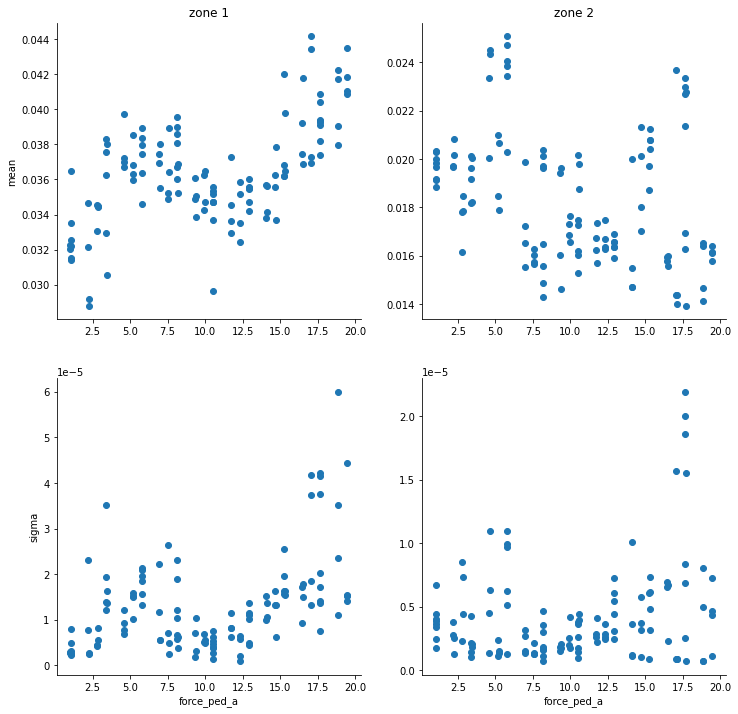

In [3]:
problem = {'num_vars': 1,
           'names': ['force_ped_a'],
           'bounds': [[1, 20]]
          }

plot_report_results(problem)

In the plots above, the top two plots show the effect of the parameter force_ped_a (strength of pedestrian interactions) on the mean population density (averaged over time) in each zone. The lower two plots show its effect on the variance of the density over time.

The two zones are affected differently. Zone 1 appears to have a faily predictably outcome on the mean density (which generally increases as force_ped_a increases), whilst zone 2 does not. The variance seems unaffected in either case.

## Maximum distance another pedestrian can be to provoke a reaction (of avoiding them)

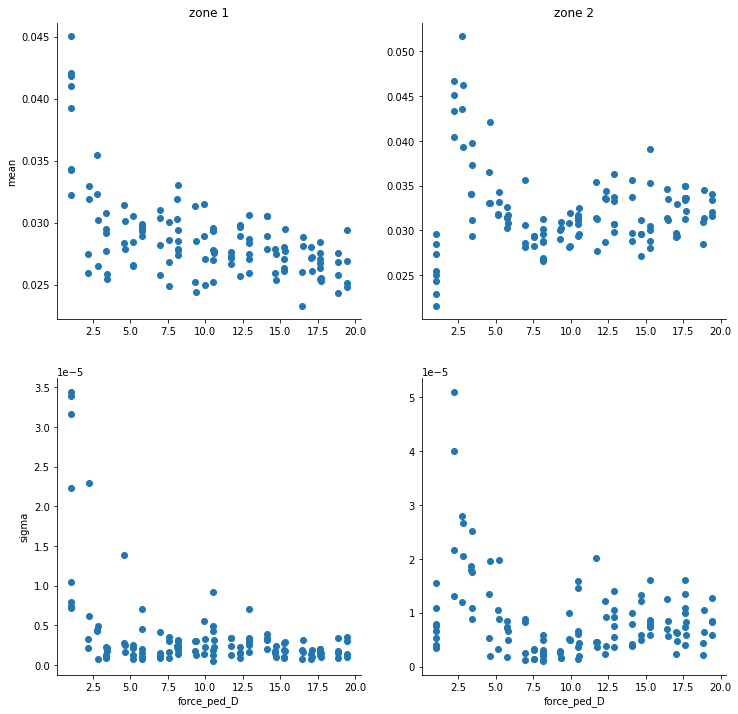

In [4]:
problem = {'num_vars': 1,
           'names': ['force_ped_D'],
           'bounds': [[1, 20]]
          }

plot_report_results(problem)

Above are the results for the effect of the distance from which a pedestrian will start evading another pedestrian that they may collide with. Where force_ped_d < 2, the zones appear to have opposite effects: the density in zone 1 increases, but in zone 2 it decreases. Where force_ped_dg > 2 there doesn't appear to be much difference.

Regarding the population variance, it appears to increase in both zones where force_ped_dg < 2, and be consistently lower where force_ped_dg > 2.

I chose 20m to be the maximum value considered as the environment is approximately 50m wide and I thought people might look far ahead when deciding their path but this doesn't seem to impact the model outcome.

## Desired mean velocity of pedestrians

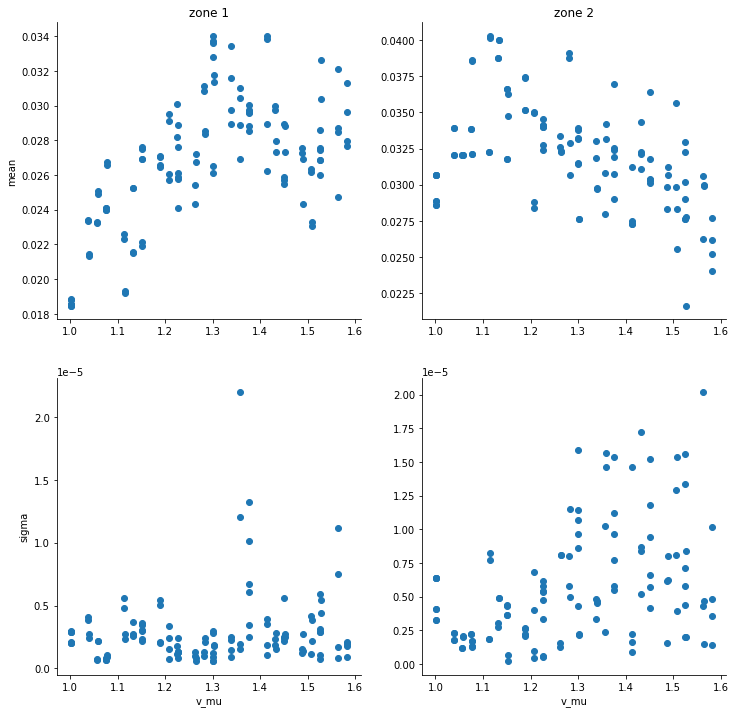

In [5]:
problem = {'num_vars': 1,
           'names': ['v_mu'],
           'bounds': [[1, 1.6]]
          }

plot_report_results(problem)

The mean desired volocity of pedestrians has opposing effects on the two zones. Note that generally, the average walking speed in the real world is 1.34 m/s. In zone 1, as we approach the real-world average, the population density increases. Above the average, it's a little less predictable but appears to dip. In zone 2, the average population density appears to decrease as the walking speed increases. The variance in zone 2 also becomes less predictable as pedestrians speed up. This does not happen in zone 1.

## Mean reaction time from noticing another pedestrian to acting to avoid them

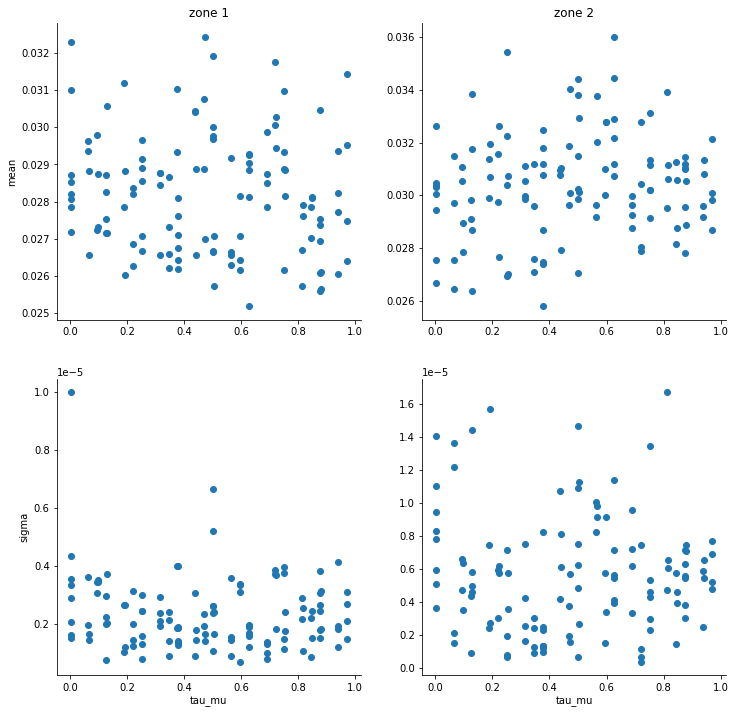

In [6]:
problem = {'num_vars': 1,
           'names': ['tau_mu'],
           'bounds': [[0.0001, 1.0]]
          }

plot_report_results(problem)

The average time it takes to react (from seeing a potential collision with a pedestrain and moving to avoid them) does not appear to have any effect on population density - at least, not within the range tested. The default value for tau_mu given by jupedsim is 0.5, so I thought exploring between 0 and 1 would show results, if any.

### What have we learnt?
Three of the parameters have different effects when comparing a region that is expected to be densely populated and one expected to be sparcely populated. This could have interesting results when calibrating the model if we handle the different parts of the environment separately.

### What are the limitations?
We haven't considered ensemble variance at all.

### What's next?
Next I'll do history matching separately for the two parts of the environment. I'll look at three of the parameters considered here (force_ped_a, force_ped_D and v_mu). Given tau_mu seemed to have no effect, I won't look into this any further. What we want to know is *do we get different results when performing history matching separately in these two zones?* Also, *does the amount of uncertainty in the model differ in the different zones?* To perform history matching we measure ensemble variance, so we won't have the same limitation as we have in this sensitivity analysis.